In [1]:
import matplotlib.pyplot as plt
import torch
import os
import PIL
from torch.utils.data import DataLoader
from transformers import DeiTFeatureExtractor

from sklearn.model_selection import train_test_split

import torch
from tqdm.auto import tqdm
from transformers import DeiTForImageClassification, get_scheduler

import seaborn as sns

2024-04-27 14:22:53.612870: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 14:22:53.639192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 14:22:54.049518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = 'Dataset_BUSI_with_GT/'
classes = os.listdir(data_dir)
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
imgs = []
lbls = []
categories_dict = {'benign': 0,
                   'malignant': 1,
                   'normal': 2}
cnt = 0
for cl in classes:
    class_path = data_dir + '/' + cl
    images = os.listdir(class_path)
    for image in images:
        index = image.find('mask')
        if index == -1:
            try:
                input = PIL.Image.open(class_path + '/' + image)
                input = input.convert('RGB')
                imgs.append(feature_extractor(input, return_tensors="pt")['pixel_values'][0])
                lbls.append(int(categories_dict[cl]))
            except:
                cnt += 1

print("Количество некорректно считанных изображений: ", cnt)

/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


Количество некорректно считанных изображений:  0


In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {}
        item['inputs'] = self.images[idx]
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [4]:
train_images, val_images, train_labels, val_labels = train_test_split(imgs, lbls, test_size=.2, stratify=lbls)
train_data = ImageDataset(train_images, train_labels)
val_data = ImageDataset(val_images, val_labels)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

classes_amount = 3
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224",
                                                  num_labels=classes_amount,
                                                  ignore_mismatched_sizes=True)

Running on the GPU


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epoch = 15
model.to(device)
model.train()

losses_for_train = []
losses_for_val = []
num_training_steps = num_epoch * len(train_loader)
lr_scheduler = get_scheduler('linear',
                             optimizer=optim,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

for epoch in range(num_epoch):
    loop = tqdm(train_loader, leave=True)
    model.train()
    for batch in loop:
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs[0]
        loss.backward()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        optim.step()
        losses_for_train.append(loss.item())
        lr_scheduler.step()
        optim.zero_grad()
    model.eval()

    for batch in val_loader:
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(inputs, labels=labels)
        loss = outputs[0]
        losses_for_val.append(loss.item())

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [6]:
def build_conf_matrix(labels, predict, class_name):
    lab, pred = [], []
    for i in range(len(labels)):
        if predict[i] == class_name:
            pred.append(0)
        else:
            pred.append(1)
        if labels[i] == class_name:
            lab.append(0)
        else:
            lab.append(1)
    return confusion_matrix(lab, pred, normalize='true')

In [7]:
model.save_pretrained(f'deit-v1.0_{num_epoch}')

<h4>Метрика при количестве эпох = 15</h4>

In [8]:
model = DeiTForImageClassification.from_pretrained(f"deit-v1.0_15/", num_labels=3, ignore_mismatched_sizes=True)
model.to(device)

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in

In [9]:
get_res = {0: "benign", 1: "malignant", 2: "normal"}

all_predictions = []
all_references = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch['labels'].cpu().numpy())

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score

print(confusion_matrix(all_predictions, all_references))
print('accuracy:{}'.format(accuracy_score(all_predictions, all_references)))
print('precision:{}'.format(precision_score(all_predictions, all_references ,average='weighted')))
print('recall:{}'.format(recall_score(all_predictions, all_references, average='weighted')))
print('f1-score:{}'.format(f1_score(all_predictions, all_references, average='weighted')))

[[82  8  2]
 [ 2 33  0]
 [ 3  1 25]]
accuracy:0.8974358974358975
precision:0.9042595867308512
recall:0.8974358974358975
f1-score:0.898611281642008


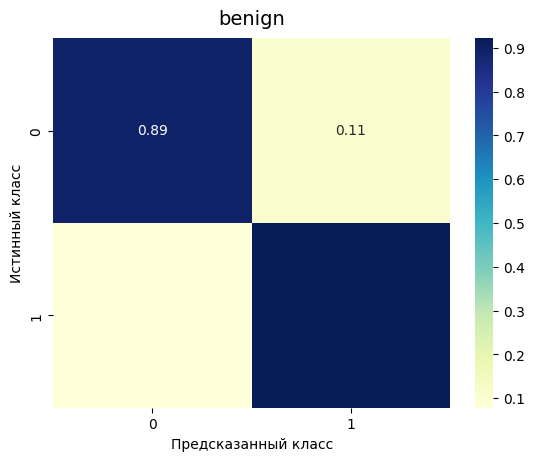

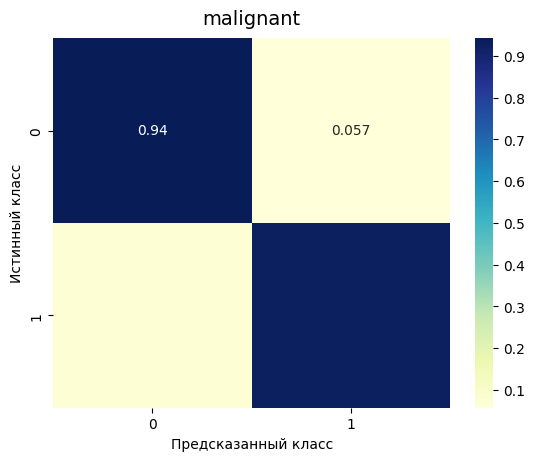

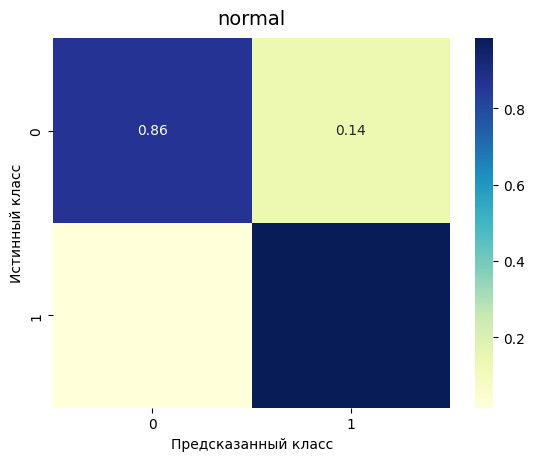

In [12]:
for i in range(classes_amount):
    heatmap = sns.heatmap(build_conf_matrix(all_predictions, all_references, i), annot=True, cmap='YlGnBu')
    heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.savefig(f"{get_res[i]}.png", dpi=300)
    plt.show()

<h4>Метрика при количестве эпох = 20</h4>

[[85  0  0]
 [ 2 42  0]
 [ 0  0 27]]
accuracy:0.9871794871794872
precision:0.9874742116121425
recall:0.9871794871794872
f1-score:0.9871049493142516


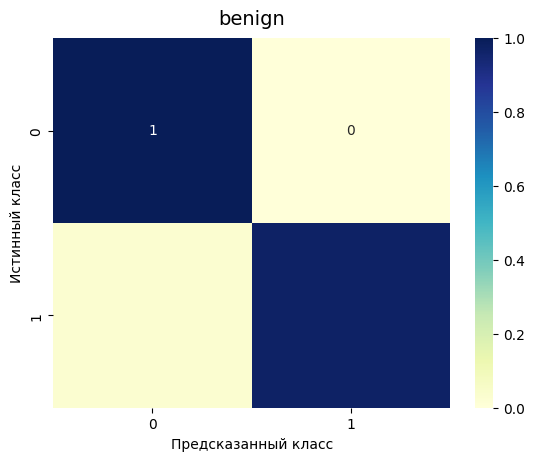

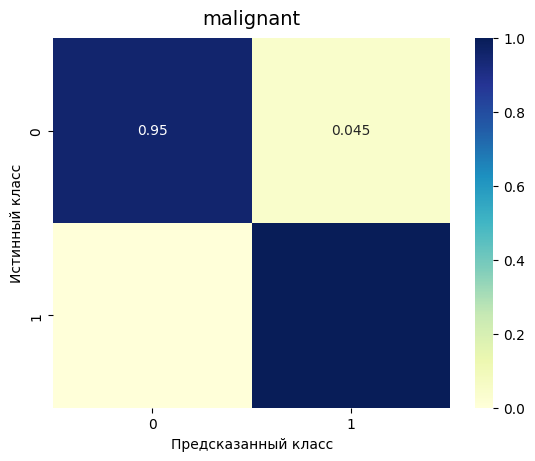

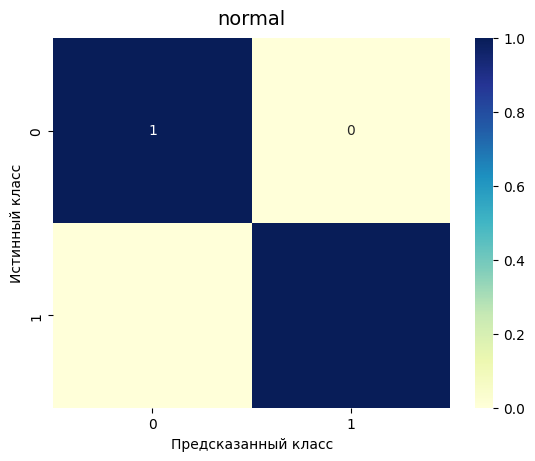

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score, roc_auc_score

model = DeiTForImageClassification.from_pretrained(f"deit-v1.0_20/", num_labels=3, ignore_mismatched_sizes=True)
model.to(device)
get_res = {0: "benign", 1: "malignant", 2: "normal"}

all_predictions = []
all_references = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch['labels'].cpu().numpy())

print(confusion_matrix(all_predictions, all_references))
print('accuracy:{}'.format(accuracy_score(all_predictions, all_references)))
print('precision:{}'.format(precision_score(all_predictions, all_references ,average='weighted')))
print('recall:{}'.format(recall_score(all_predictions, all_references, average='weighted')))
print('f1-score:{}'.format(f1_score(all_predictions, all_references, average='weighted')))

for i in range(classes_amount):
    heatmap = sns.heatmap(build_conf_matrix(all_predictions, all_references, i), annot=True, cmap='YlGnBu')
    heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.savefig(f"{get_res[i]}.png", dpi=300)
    plt.show()

<h4>Метрика при количестве эпох = 30</h4>

[[86  0  0]
 [ 0 42  0]
 [ 1  0 27]]
accuracy:0.9935897435897436
precision:0.9936634246979074
recall:0.9935897435897436
f1-score:0.9935499952840994


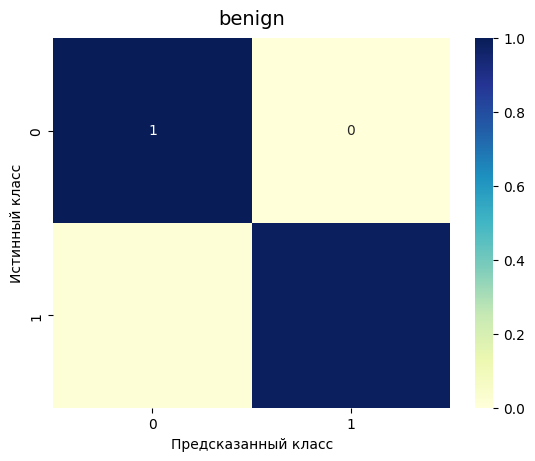

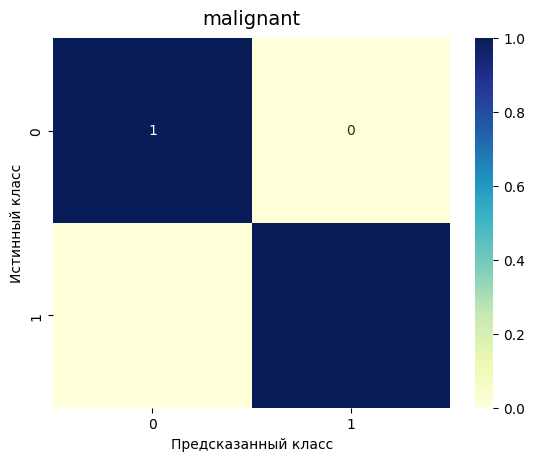

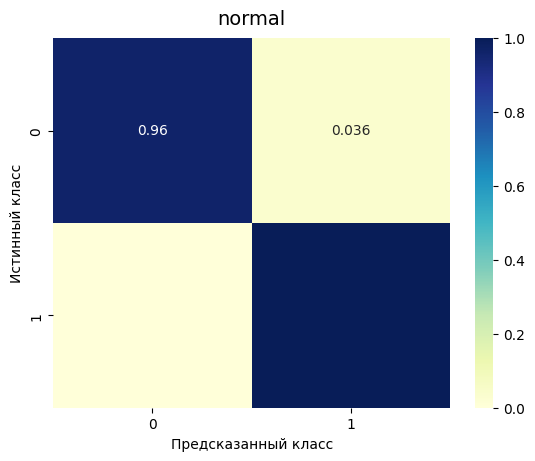

In [7]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score, roc_auc_score

model = DeiTForImageClassification.from_pretrained(f"deit-v1.0_30/", num_labels=3, ignore_mismatched_sizes=True)
model.to(device)
get_res = {0: "benign", 1: "malignant", 2: "normal"}

all_predictions = []
all_references = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch['labels'].cpu().numpy())

print(confusion_matrix(all_predictions, all_references))
print('accuracy:{}'.format(accuracy_score(all_predictions, all_references)))
print('precision:{}'.format(precision_score(all_predictions, all_references ,average='weighted')))
print('recall:{}'.format(recall_score(all_predictions, all_references, average='weighted')))
print('f1-score:{}'.format(f1_score(all_predictions, all_references, average='weighted')))

for i in range(classes_amount):
    heatmap = sns.heatmap(build_conf_matrix(all_predictions, all_references, i), annot=True, cmap='YlGnBu')
    heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.savefig(f"{get_res[i]}.png", dpi=300)
    plt.show()

<h4>Метрика при количестве эпох = 50</h4>

[[85  2  0]
 [ 2 40  1]
 [ 0  0 26]]
accuracy:0.967948717948718
precision:0.9678808845475511
recall:0.967948717948718
f1-score:0.967820655112553


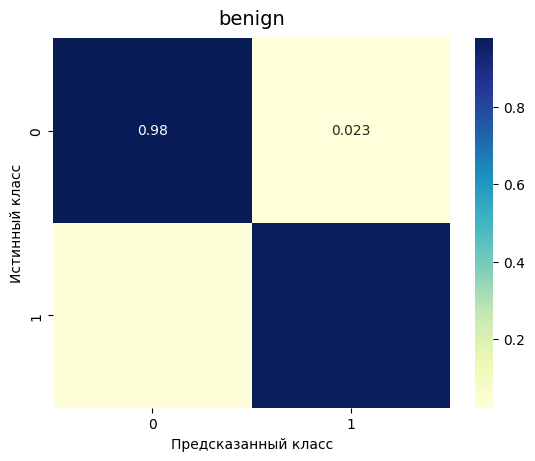

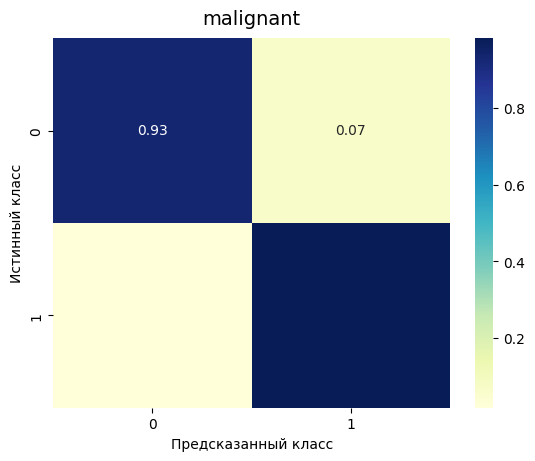

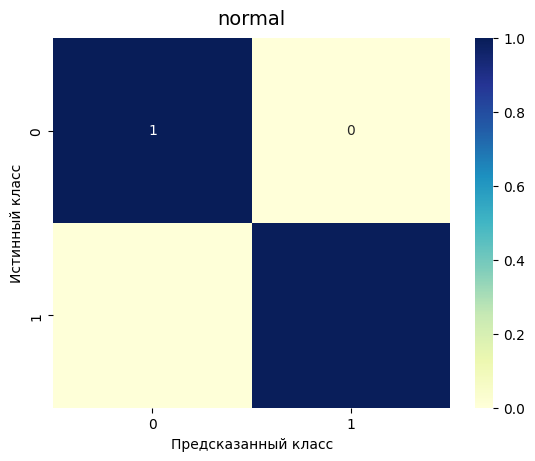

In [7]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score, roc_auc_score

model = DeiTForImageClassification.from_pretrained(f"deit-v1.0_50/", num_labels=3, ignore_mismatched_sizes=True)
model.to(device)
get_res = {0: "benign", 1: "malignant", 2: "normal"}

all_predictions = []
all_references = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch['labels'].cpu().numpy())

print(confusion_matrix(all_predictions, all_references))
print('accuracy:{}'.format(accuracy_score(all_predictions, all_references)))
print('precision:{}'.format(precision_score(all_predictions, all_references ,average='weighted')))
print('recall:{}'.format(recall_score(all_predictions, all_references, average='weighted')))
print('f1-score:{}'.format(f1_score(all_predictions, all_references, average='weighted')))

for i in range(classes_amount):
    heatmap = sns.heatmap(build_conf_matrix(all_predictions, all_references, i), annot=True, cmap='YlGnBu')
    heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.savefig(f"{get_res[i]}.png", dpi=300)
    plt.show()